In [1]:
import sys

import pandas as pd

sys.path.append("..")

import tsflex

print("using tsflex verion: ", tsflex.__version__)

using tsflex verion:  0.3.0


## Get the data

In [2]:
from tsflex.utils.data import load_empatica_data

df_tmp, df_acc, df_gsr, df_ibi = load_empatica_data(["tmp", "acc", "gsr", "ibi"])
data = [df_tmp, df_acc, df_gsr, df_ibi]

In [3]:
from pandas.tseries.frequencies import to_offset

for df in [df_tmp, df_acc, df_gsr, df_ibi]:
    print("Time-series:", df.columns.values)
    print(df.shape)
    try:
        print(
            "Sampling rate:",
            1 / pd.to_timedelta(to_offset(pd.infer_freq(df.index))).total_seconds(),
            "Hz\n",
        )
    except:
        print("Irregular sampling rate\n")

Time-series: ['TMP']
(30200, 1)
Sampling rate: 4.0 Hz

Time-series: ['ACC_x' 'ACC_y' 'ACC_z']
(241620, 3)
Sampling rate: 32.0 Hz

Time-series: ['EDA']
(30204, 1)
Sampling rate: 4.0 Hz

Time-series: ['IBI']
(1230, 1)
Irregular sampling rate



## Look at the data

In [4]:
# %pip install plotly kaleido
from plotly.subplots import make_subplots
import plotly.graph_objects as go

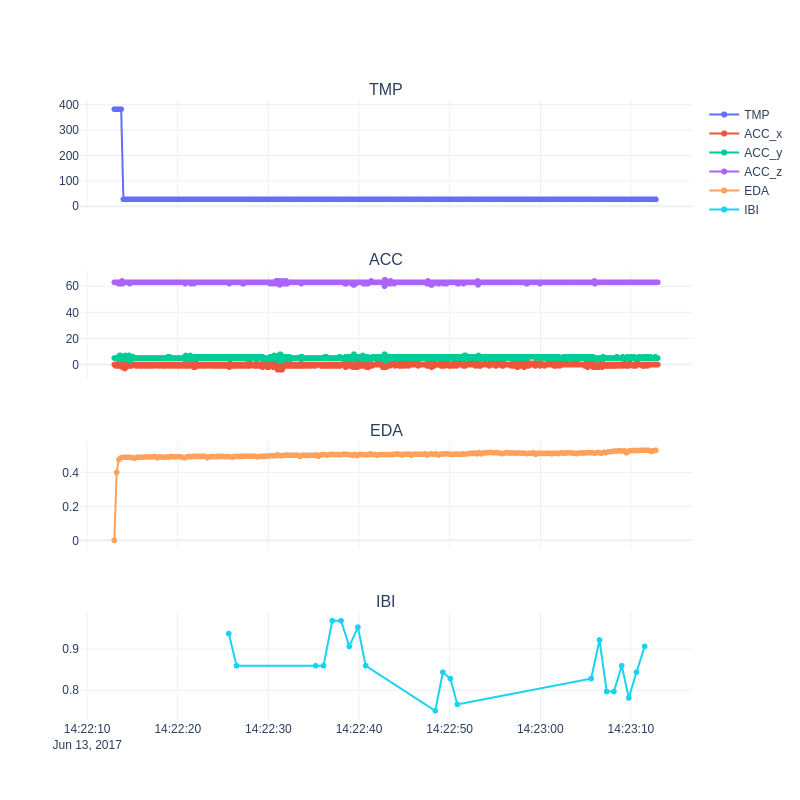

In [5]:
fig = make_subplots(
    rows=len(data),
    cols=1,
    shared_xaxes=True,
    subplot_titles=[df.columns.values[0].split("_")[0] for df in data],
    vertical_spacing=0.1,
)

for plot_idx, df in enumerate(data, 1):
    # Select first minute of data
    sub_df = df.first("1min")
    for col in df.columns:
        fig.add_trace(
            go.Scattergl(
                x=sub_df.index, y=sub_df[col].values, name=col, mode="lines+markers"
            ),
            row=plot_idx,
            col=1,
        )
fig.update_layout(template="plotly_white")
fig.show(renderer="png", height=len(data) * 200, width=800)

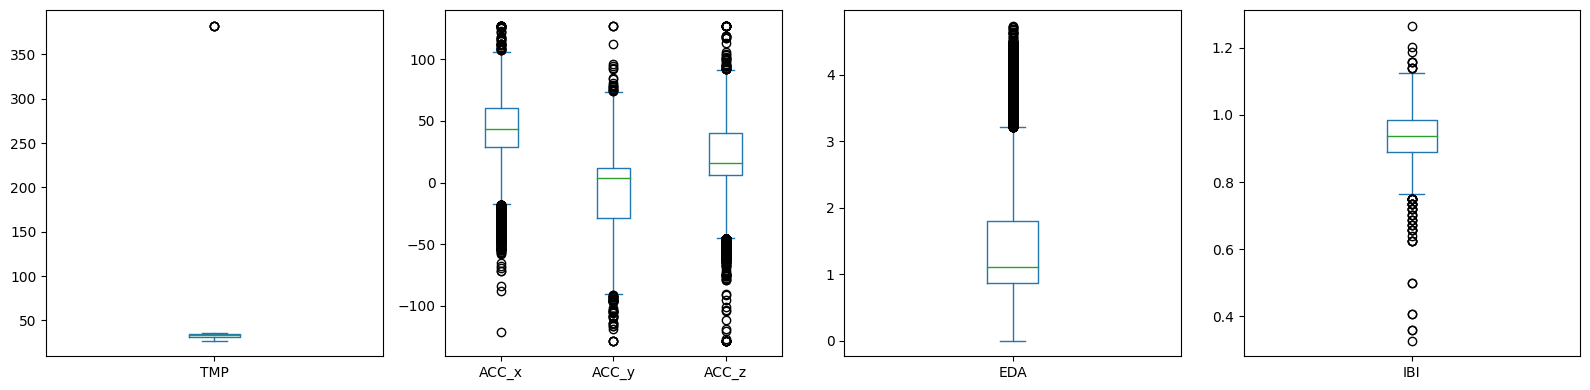

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

for plot_idx, df in enumerate(data):
    df.plot(kind="box", ax=axes[plot_idx])
plt.tight_layout()

These visualizations indicate that some preprocessing might be necessary for the signals (some sort of clipping)

# tsflex processing

This is roughly identical to the processing of [this paper notebook](https://github.com/predict-idlab/tsflex/blob/main/examples/tsflex_paper.ipynb)

In [7]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from tsflex.processing import SeriesProcessor, SeriesPipeline

# Create the processing functions
def clip_data(sig: pd.Series, min_val=None, max_val=None) -> np.ndarray:
    return np.clip(sig, a_min=min_val, a_max=max_val)


def smv(*sigs) -> pd.Series:
    sig_prefixes = set(sig.name.split("_")[0] for sig in sigs)
    result = np.sqrt(np.sum([np.square(sig) for sig in sigs], axis=0))
    return pd.Series(
        result, index=sigs[0].index, name="|".join(sig_prefixes) + "_" + "SMV"
    )


# Create the series processors (with their keyword arguments)
tmp_clippper = SeriesProcessor(clip_data, series_names="TMP", max_val=35)
acc_savgol = SeriesProcessor(
    savgol_filter, ["ACC_x", "ACC_y", "ACC_z"], window_length=33, polyorder=2
)
acc_smv = SeriesProcessor(smv, ("ACC_x", "ACC_y", "ACC_z"))

# Create the series pipeline & process the data
series_pipe = SeriesPipeline([tmp_clippper, acc_savgol, acc_smv])
series_pipe


[
	clip_data {'max_val': 35} :  ('TMP',)
	savgol_filter {'window_length': 33, 'polyorder': 2} :  ('ACC_x',) ('ACC_y',) ('ACC_z',)
	smv {} :  ('ACC_x', 'ACC_y', 'ACC_z')
]

In [8]:
out_data = series_pipe.process(data, drop_keys=["ACC_x", "ACC_y", "ACC_z"])


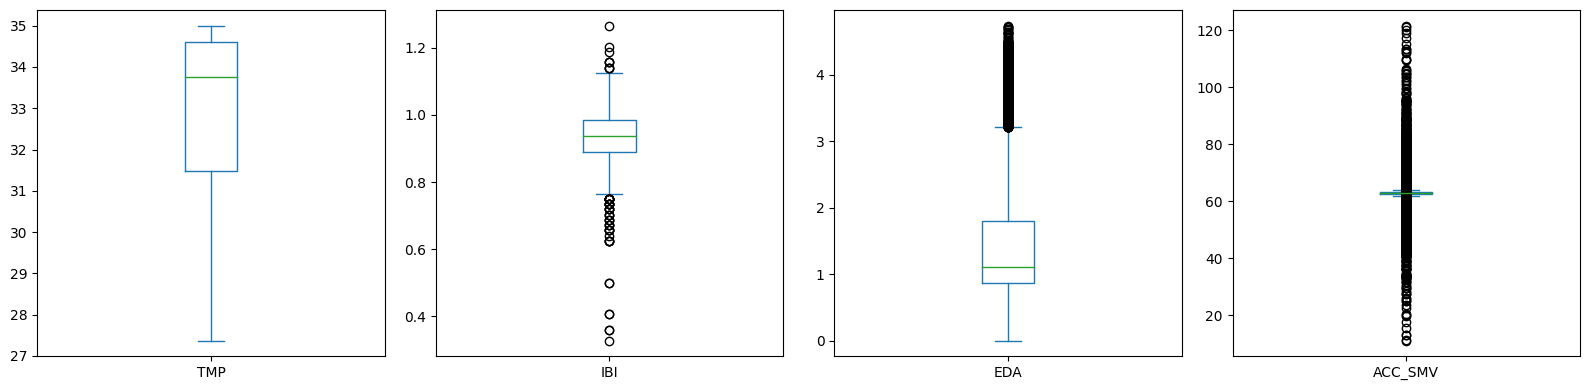

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

for plot_idx, df in enumerate(out_data):
    df.plot(kind="box", ax=axes[plot_idx])
plt.tight_layout()


# tsflex feature extraction with [antropy](https://github.com/raphaelvallat/antropy) integration

In [10]:
# !pip install antropy


> Useful links;  
> [More detailed documentation of the antropy features](https://raphaelvallat.com/antropy/build/html/api.html)  

**<i>basic</i> `antropy` features**:  
Most `antropy` features are simple functions that return 1 value, and have no mandatory keyword arguments. As a result, they can be used directly in tsflex. However, if you want to change the default value of one of the keywords arguments, you can wrap the function in a `FuncWrapper` object. 

**<i>advanced</i> `antropy` features**:  
`antropy` features that should always be wrapped with a `FuncWrapper` are;
* `spectral_entropy` (because it requires the `fs` keyword argument)
* `hjorth_params` (because it returns 2 values)

In [11]:
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors

## Using basic antropy features

In [12]:
# %pip install antropy
import antropy as ant

In [13]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection

to_wrap_features = ["spectral_entropy", "hjorth_params"]

# All fractal features are "basic"
fractal_features = [getattr(ant, f) for f in ant.fractal.all]
# All entropy features are "basic" except for the ones that are in to_wrap_features
entropy_features = [
    getattr(ant, f) for f in ant.entropy.all if f not in to_wrap_features
]

basic_funcs = fractal_features  # + entropy_features

basic_feats = MultipleFeatureDescriptors(
    functions=basic_funcs,
    series_names=["ACC_SMV", "EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides="2min",
)
feature_collection = FeatureCollection(basic_feats)
feature_collection

ACC_SMV: (
	win: 5m    : [
		FeatureDescriptor - func: FuncWrapper(petrosian_fd, ['petrosian_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(katz_fd, ['katz_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(higuchi_fd, ['higuchi_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(detrended_fluctuation, ['detrended_fluctuation'], {})    stride: ['2m'],
	]
	win: 2m30s : [
		FeatureDescriptor - func: FuncWrapper(petrosian_fd, ['petrosian_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(katz_fd, ['katz_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(higuchi_fd, ['higuchi_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(detrended_fluctuation, ['detrended_fluctuation'], {})    stride: ['2m'],
	]
)
EDA: (
	win: 5m    : [
		FeatureDescriptor - func: FuncWrapper(petrosian_fd, ['petrosian_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(katz_fd, ['katz_fd'], {

In [14]:
features_df = feature_collection.calculate(out_data, return_df=True, n_jobs=1)
features_df

/home/jeroen/.cache/pypoetry/virtualenvs/tsflex-5Y4iXlk8-py3.10/lib/python3.10/site-packages/antropy/fractal.py:188: RuntimeWarning:

invalid value encountered in float_scalars

/home/jeroen/.cache/pypoetry/virtualenvs/tsflex-5Y4iXlk8-py3.10/lib/python3.10/site-packages/antropy/fractal.py:191: RuntimeWarning:

invalid value encountered in float_scalars



,ACC_SMV__detrended_fluctuation__w=2m30s,ACC_SMV__detrended_fluctuation__w=5m,ACC_SMV__higuchi_fd__w=2m30s,ACC_SMV__higuchi_fd__w=5m,ACC_SMV__katz_fd__w=2m30s,ACC_SMV__katz_fd__w=5m,ACC_SMV__petrosian_fd__w=2m30s,ACC_SMV__petrosian_fd__w=5m,EDA__detrended_fluctuation__w=2m30s,EDA__detrended_fluctuation__w=5m,...,EDA__petrosian_fd__w=2m30s,EDA__petrosian_fd__w=5m,TMP__detrended_fluctuation__w=2m30s,TMP__detrended_fluctuation__w=5m,TMP__higuchi_fd__w=2m30s,TMP__higuchi_fd__w=5m,TMP__katz_fd__w=2m30s,TMP__katz_fd__w=5m,TMP__petrosian_fd__w=2m30s,TMP__petrosian_fd__w=5m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,0.941559,NaN,1.154598,NaN,1.680309,NaN,1.013109,NaN,1.329277,NaN,...,1.032265,NaN,3.735441,NaN,1.354905,NaN,1.039171,NaN,1.006777,NaN
2017-06-13 14:26:43+02:00,1.040427,NaN,1.237536,NaN,1.876742,NaN,1.012756,NaN,1.274529,NaN,...,1.030073,NaN,4.151773,NaN,1.167369,NaN,1.093288,NaN,1.004131,NaN
2017-06-13 14:27:13+02:00,NaN,0.906367,NaN,1.206279,NaN,1.935107,NaN,1.011634,NaN,1.253517,...,NaN,1.028856,NaN,2.458577,NaN,1.315036,NaN,1.066482,NaN,1.005013
2017-06-13 14:28:43+02:00,0.852312,NaN,1.246614,NaN,1.693338,NaN,1.012138,NaN,1.410375,NaN,...,1.035337,NaN,4.101882,NaN,1.221960,NaN,1.160544,NaN,1.006169,NaN
2017-06-13 14:29:13+02:00,NaN,0.940747,NaN,1.250266,NaN,1.867781,NaN,1.011613,NaN,1.278036,...,NaN,1.029141,NaN,3.223988,NaN,1.190755,NaN,1.116491,NaN,1.005380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:23:13+02:00,NaN,0.784357,NaN,1.298512,NaN,1.891076,NaN,1.016849,NaN,1.395108,...,NaN,1.030522,NaN,3.110723,NaN,1.279513,NaN,1.187024,NaN,1.006110
2017-06-13 16:24:43+02:00,0.873859,NaN,1.186941,NaN,1.783159,NaN,1.016517,NaN,1.263505,NaN,...,1.029430,NaN,4.194719,NaN,1.309962,NaN,1.760259,NaN,1.008189,NaN
2017-06-13 16:25:13+02:00,NaN,0.771254,NaN,1.212887,NaN,1.841699,NaN,1.015690,NaN,1.300013,...,NaN,1.027176,NaN,3.211570,NaN,1.270637,NaN,1.292549,NaN,1.006566


### Plot the EDA features

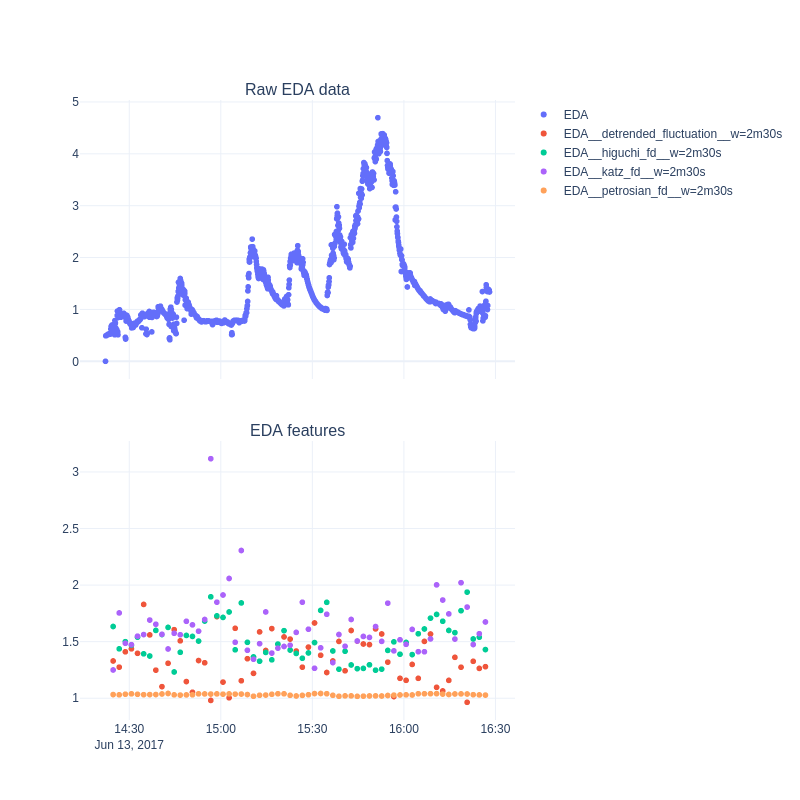

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    subplot_titles=["Raw EDA data", "EDA features"],
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scattergl(
        x=df_gsr.index[:: 4 * 5],
        y=df_gsr["EDA"].values[:: 4 * 5],
        name="EDA",
        mode="markers",
    ),
    row=1,
    col=1,
)

ibi_feats = [c for c in features_df.columns if "EDA_" in c and "w=2m30s" in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode="markers"),
        row=2,
        col=1,
    )

fig.update_layout(template="plotly_white")
fig.show(renderer="png", height=len(data) * 200, width=800)

## Using advanced features

In [16]:
# Import some "advanced" tsfel features
from tsfel.feature_extraction.features import (
    # Some temporal features
    calc_centroid,
    auc,
    entropy,
    neighbourhood_peaks,
    # Some statistical features
    hist,
    ecdf,
    ecdf_percentile_count,
    # Some spectral features
    spectral_distance,
    fundamental_frequency,
    max_power_spectrum,
    spectral_centroid,
    spectral_decrease,
    spectral_kurtosis,
    spectral_spread,
    human_range_energy,
    mfcc,
    fft_mean_coeff,
    wavelet_abs_mean,
    wavelet_std,
    wavelet_energy,
)

In [17]:
# Import all feature functions from seg-learn

from tsflex.features import FeatureCollection, MultipleFeatureDescriptors, FuncWrapper

advanced_feats = MultipleFeatureDescriptors(
    functions=[
        # Temporal
        FuncWrapper(calc_centroid, fs=4),
        FuncWrapper(auc, fs=4),
        FuncWrapper(entropy, prob="kde", output_names="entropy_kde"),
        FuncWrapper(entropy, prob="gauss", output_names="entropy_gauss"),
        FuncWrapper(neighbourhood_peaks, n=5, output_names="neighbourhood_peaks_n=5"),
        # Statistical
        FuncWrapper(hist, nbins=4, output_names=[f"hist{i}" for i in range(1, 5)]),
        FuncWrapper(ecdf, output_names=[f"ecdf{i}" for i in range(1, 11)]),
        FuncWrapper(ecdf_percentile_count, output_names=["ecdf_0.2", "ecdf_0.8"]),
        # Spectral
        FuncWrapper(spectral_distance, fs=4),
        FuncWrapper(fundamental_frequency, fs=4),
        FuncWrapper(max_power_spectrum, fs=4),
        FuncWrapper(spectral_centroid, fs=4),
        FuncWrapper(spectral_decrease, fs=4),
        FuncWrapper(spectral_kurtosis, fs=4),
        FuncWrapper(spectral_spread, fs=4),
        FuncWrapper(human_range_energy, fs=4),
        FuncWrapper(
            mfcc, fs=4, num_ceps=6, output_names=[f"mfcc{i}" for i in range(1, 7)]
        ),
        FuncWrapper(
            fft_mean_coeff,
            fs=4,
            nfreq=8,
            output_names=[f"fft_mean_coeff_{i}" for i in range(8)],
        ),
        FuncWrapper(
            wavelet_abs_mean,
            output_names=[f"wavelet_abs_mean_{i}" for i in range(1, 10)],
        ),
        FuncWrapper(
            wavelet_std, output_names=[f"wavelet_std_{i}" for i in range(1, 10)]
        ),
        FuncWrapper(
            wavelet_energy,
            widths=np.arange(1, 5),
            output_names=[f"wavelet_energy_{i}" for i in range(1, 5)],
        ),
    ],
    series_names=["EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides=["2.5min"],
)
feature_collection = FeatureCollection(advanced_feats)
feature_collection

EDA: (
	win: 5m    : [
		FeatureDescriptor - func: FuncWrapper(calc_centroid, ['calc_centroid'], {'fs': 4})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(auc, ['auc'], {'fs': 4})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(entropy, ['entropy_kde'], {'prob': 'kde'})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(entropy, ['entropy_gauss'], {'prob': 'gauss'})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(neighbourhood_peaks, ['neighbourhood_peaks_n=5'], {'n': 5})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(hist, ['hist1', 'hist2', 'hist3', 'hist4'], {'nbins': 4})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(ecdf, ['ecdf1', 'ecdf2', 'ecdf3', 'ecdf4', 'ecdf5', 'ecdf6', 'ecdf7', 'ecdf8', 'ecdf9', 'ecdf10'], {})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(ecdf_percentile_count, ['ecdf_0.2', 'ecdf_0.8'], {})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(spectra

In [18]:
features_df = feature_collection.calculate(
    out_data, return_df=True, logging_file_path="tsfel_advanced.log"
)
features_df

/home/jeroen/Git/tsflex/tsflex/utils/logging.py:81: RuntimeWarning:

Logging file (tsfel_advanced.log) already exists. This file will be overwritten!



,EDA__auc__w=2m30s,EDA__auc__w=5m,EDA__calc_centroid__w=2m30s,EDA__calc_centroid__w=5m,EDA__ecdf10__w=2m30s,EDA__ecdf10__w=5m,EDA__ecdf1__w=2m30s,EDA__ecdf1__w=5m,EDA__ecdf2__w=2m30s,EDA__ecdf2__w=5m,...,TMP__wavelet_std_5__w=2m30s,TMP__wavelet_std_5__w=5m,TMP__wavelet_std_6__w=2m30s,TMP__wavelet_std_6__w=5m,TMP__wavelet_std_7__w=2m30s,TMP__wavelet_std_7__w=5m,TMP__wavelet_std_8__w=2m30s,TMP__wavelet_std_8__w=5m,TMP__wavelet_std_9__w=2m30s,TMP__wavelet_std_9__w=5m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,82.461837,NaN,82.421866,NaN,0.016667,NaN,0.001667,NaN,0.003333,NaN,...,5.002295,NaN,5.841184,NaN,6.686805,NaN,7.535821,NaN,8.385133,NaN
2017-06-13 14:27:13+02:00,110.133445,192.741149,86.359785,182.039215,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,4.790044,3.638882,5.719857,4.260856,6.643068,4.889749,7.559655,5.523707,8.469133,6.160773
2017-06-13 14:29:43+02:00,125.093583,235.439719,72.334050,162.267442,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,4.937297,3.453637,5.897790,4.133228,6.850188,4.810630,7.793730,5.485410,8.728434,6.157382
2017-06-13 14:32:13+02:00,107.177666,232.470191,72.860379,135.431617,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.085715,3.597735,6.074760,4.306468,7.055956,5.012328,8.029210,5.714820,8.994736,6.413956
2017-06-13 14:34:43+02:00,120.859006,228.216110,79.609944,160.756980,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.287628,3.706909,6.315705,4.436043,7.336195,5.162769,8.348876,5.887268,9.353768,6.609739
2017-06-13 14:37:13+02:00,126.219086,247.297018,77.648459,157.409647,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.367532,3.757065,6.411893,4.497287,7.448961,5.235573,8.479117,5.972034,9.502458,6.706728
2017-06-13 14:39:43+02:00,136.526782,262.980798,77.413766,157.821477,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.378170,3.849494,6.422858,4.606399,7.458840,5.360261,8.486683,6.111283,9.506673,6.859552
2017-06-13 14:42:13+02:00,143.676892,280.456829,71.233357,152.823419,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.461435,3.892793,6.522403,4.658510,7.574513,5.420975,8.618698,6.180828,9.655310,6.938363
2017-06-13 14:44:43+02:00,119.428576,263.324091,74.143830,135.143790,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.524432,3.892039,6.597226,4.656987,7.661200,5.418797,8.716405,6.177796,9.762978,6.934192


### Plot the EDA features

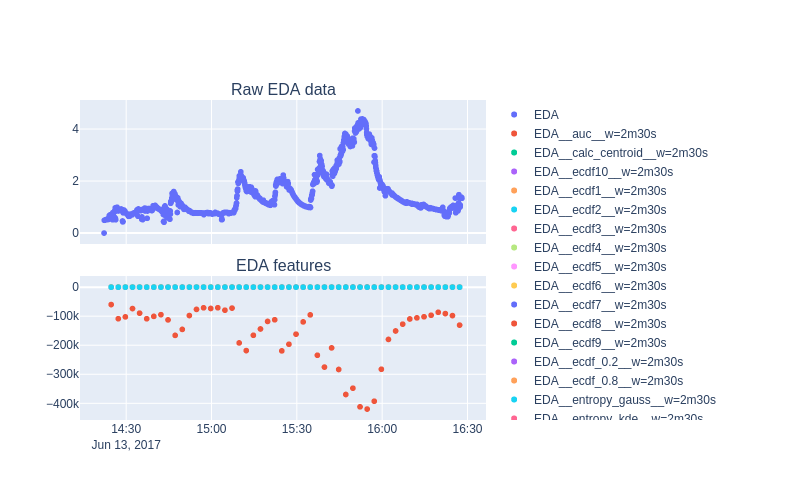

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    subplot_titles=["Raw EDA data", "EDA features"],
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scattergl(
        x=df_gsr.index[:: 4 * 5],
        y=df_gsr["EDA"].values[:: 4 * 5],
        name="EDA",
        mode="markers",
    ),
    row=1,
    col=1,
)

eda_feats = [c for c in features_df.columns if "EDA_" in c and "w=2m30s" in c]

for col in eda_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode="markers"),
        row=2,
        col=1,
    )

fig.update_layout(height=2 * 350)

fig.show(renderer="png", height=500, width=800)
